# **Klasifikasi Gerakan untuk Rehabilitasi Stroke Menggunakan LSTM**
Dataset yang akan digunakan adalah 10 video gerakan rehabilitasi untuk pasien stroke yang ditemukan di Internet.

Proyek ini bertujuan untuk mendeteksi gerakan ....

# **1. Import Library**

In [33]:
import os
import cv2
import pandas as pd
import numpy as np
import time
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from ultralytics import YOLO
from sklearn.preprocessing import StandardScaler

# **2. Memuat Dataset**

In [34]:
# --- 2. Memuat Dataset ---
# Setup Folders for Collection
VIDEO_DIR = 'dataset_video' 
sequence_length = 30         # frame per sequence (akan di-resample ke sini)
RANDOM_SEED     = 42

actions = sorted([d for d in os.listdir(VIDEO_DIR)
                  if os.path.isdir(os.path.join(VIDEO_DIR,d))])
print('Kelas terdeteksi:', actions, '\n')

vid_dict = defaultdict(list)   # {action: [video_path, …]}
for act in actions:
    for f in sorted(os.listdir(os.path.join(VIDEO_DIR,act))):
        if f.lower().endswith(('.mp4','.mov','.avi','.mkv')):\
            vid_dict[act].append(os.path.join(VIDEO_DIR,act,f))


Kelas terdeteksi: ['Angkat Pinggul', 'Angkat Tangan', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'] 



# **3. Exploratory Data Analysis (EDA)**

,action,video,fps,frames,duration
0,Angkat Pinggul,1.MOV,59.953704,259,4.320000
1,Angkat Pinggul,10.mp4,30.000000,104,3.466667
2,Angkat Pinggul,11.mp4,29.836711,153,5.127911
3,Angkat Pinggul,12.mp4,30.031600,134,4.461967
4,Angkat Pinggul,13.mp4,30.031612,114,3.796000
...,...,...,...,...,...
95,Rentangkan,5.MOV,29.971182,156,5.205000
96,Rentangkan,6.MOV,59.970312,202,3.368333
97,Rentangkan,7.mp4,30.000000,142,4.733333
98,Rentangkan,8.mp4,30.000000,155,5.166667


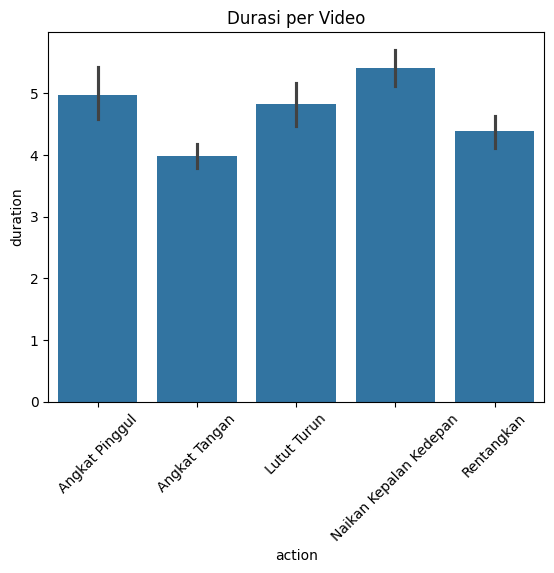

In [35]:
# --- 3. Exploratory Data Analysis (EDA) ---
rows=[]
for act in actions:
    for vp in vid_dict[act]:
        cap=cv2.VideoCapture(vp)
        fps  = cap.get(cv2.CAP_PROP_FPS) or 30
        nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        dur  = nfrm/fps
        rows.append(dict(action=act, video=os.path.basename(vp),\
                         fps=fps, frames=nfrm, duration=dur))
        cap.release()
df=pd.DataFrame(rows)
display(df)
sns.barplot(data=df,x='action',y='duration')
plt.xticks(rotation=45); plt.title('Durasi per Video'); plt.show()

# **4. Preprocessing**

### Ekstraksi Keypoints


In [36]:
# --- 4. Preprocessing - Ekstraksi Keypoints ---
print("\n--- Ekstraksi Keypoints ---")
pose_model = YOLO("yolov8n-pose.pt")  
keypoint_root = "keypoints Rombak Preprocessing"    

if not os.path.exists(keypoint_root):
    os.makedirs(keypoint_root)

for action in actions:
    video_dir = os.path.join(VIDEO_DIR, action)
    save_dir = os.path.join(keypoint_root, action)
    os.makedirs(save_dir, exist_ok=True)

    for video_name in tqdm(os.listdir(video_dir), desc=f"Proses {action}"):
        video_path = os.path.join(video_dir, video_name)
        cap = cv2.VideoCapture(video_path)
        sequence = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            results = pose_model.predict(source=frame, conf=0.5, save=False, verbose=False)
            
            if results and len(results[0].keypoints.xy) > 0:
                kps = results[0].keypoints.xy[0].cpu().numpy()  
                
                if kps.shape[0] == 17:  
                    h, w, _ = frame.shape
                    normalized_kps = kps / np.array([w, h])
                    sequence.append(normalized_kps.flatten())  
                else:
                    sequence.append(np.zeros(17 * 2)) 
            else:
                sequence.append(np.zeros(17 * 2))

        cap.release()

        if len(sequence) > 0:
            try:
                sequence = np.array(sequence)
                save_path = os.path.join(save_dir, video_name.replace(".MOV", ".npy").replace(".mp4", ".npy"))
                np.save(save_path, sequence)
                print(f"✅ Keypoint disimpan: {save_path}")
            except ValueError as e:
                print(f"❌ Gagal menyimpan {video_name}: {e}")
        else:
            print(f"⚠️ Tidak ada keypoint valid di {video_name}")


--- Ekstraksi Keypoints ---


Proses Angkat Pinggul:   5%|▌         | 1/20 [00:11<03:45, 11.87s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\1.npy


Proses Angkat Pinggul:  10%|█         | 2/20 [00:16<02:16,  7.59s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\10.npy


Proses Angkat Pinggul:  15%|█▌        | 3/20 [00:23<02:04,  7.34s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\11.npy


Proses Angkat Pinggul:  20%|██        | 4/20 [00:29<01:49,  6.86s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\12.npy


Proses Angkat Pinggul:  25%|██▌       | 5/20 [00:34<01:32,  6.15s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\13.npy


Proses Angkat Pinggul:  30%|███       | 6/20 [00:40<01:27,  6.23s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\14.npy


Proses Angkat Pinggul:  35%|███▌      | 7/20 [00:47<01:22,  6.33s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\15.npy


Proses Angkat Pinggul:  40%|████      | 8/20 [00:54<01:19,  6.61s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\16.npy


Proses Angkat Pinggul:  45%|████▌     | 9/20 [01:00<01:09,  6.28s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\17.npy


Proses Angkat Pinggul:  50%|█████     | 10/20 [01:05<00:59,  5.99s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\18.npy


Proses Angkat Pinggul:  55%|█████▌    | 11/20 [01:12<00:56,  6.33s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\19.npy


Proses Angkat Pinggul:  60%|██████    | 12/20 [01:25<01:05,  8.24s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\2.npy


Proses Angkat Pinggul:  65%|██████▌   | 13/20 [01:32<00:55,  7.88s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\20.npy


Proses Angkat Pinggul:  70%|███████   | 14/20 [01:38<00:43,  7.24s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\3.npy


Proses Angkat Pinggul:  75%|███████▌  | 15/20 [01:44<00:34,  6.85s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\4.npy


Proses Angkat Pinggul:  80%|████████  | 16/20 [01:52<00:28,  7.20s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\5.npy


Proses Angkat Pinggul:  85%|████████▌ | 17/20 [01:56<00:19,  6.39s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\6.npy


Proses Angkat Pinggul:  90%|█████████ | 18/20 [02:02<00:12,  6.34s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\7.npy


Proses Angkat Pinggul:  95%|█████████▌| 19/20 [02:10<00:06,  6.74s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\8.npy


Proses Angkat Pinggul: 100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Pinggul\9.npy


Proses Angkat Tangan:   5%|▌         | 1/20 [00:04<01:31,  4.82s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\1.npy


Proses Angkat Tangan:  10%|█         | 2/20 [00:09<01:26,  4.81s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\10.npy


Proses Angkat Tangan:  15%|█▌        | 3/20 [00:14<01:23,  4.91s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\11.npy


Proses Angkat Tangan:  20%|██        | 4/20 [00:20<01:24,  5.27s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\12.npy


Proses Angkat Tangan:  25%|██▌       | 5/20 [00:23<01:07,  4.50s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\13.npy


Proses Angkat Tangan:  30%|███       | 6/20 [00:29<01:10,  5.04s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\14.npy


Proses Angkat Tangan:  35%|███▌      | 7/20 [00:36<01:11,  5.48s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\15.npy


Proses Angkat Tangan:  40%|████      | 8/20 [00:41<01:07,  5.61s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\16.npy


Proses Angkat Tangan:  45%|████▌     | 9/20 [00:47<01:01,  5.55s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\17.npy


Proses Angkat Tangan:  50%|█████     | 10/20 [00:51<00:50,  5.08s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\18.npy


Proses Angkat Tangan:  55%|█████▌    | 11/20 [00:57<00:47,  5.33s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\19.npy


Proses Angkat Tangan:  60%|██████    | 12/20 [01:01<00:39,  4.90s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\2.npy


Proses Angkat Tangan:  65%|██████▌   | 13/20 [01:06<00:34,  4.95s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\20.npy


Proses Angkat Tangan:  70%|███████   | 14/20 [01:12<00:31,  5.26s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\3.npy


Proses Angkat Tangan:  75%|███████▌  | 15/20 [01:16<00:24,  4.96s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\4.npy


Proses Angkat Tangan:  80%|████████  | 16/20 [01:21<00:20,  5.12s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\5.npy


Proses Angkat Tangan:  85%|████████▌ | 17/20 [01:28<00:16,  5.52s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\6.npy


Proses Angkat Tangan:  90%|█████████ | 18/20 [01:34<00:11,  5.54s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\7.npy


Proses Angkat Tangan:  95%|█████████▌| 19/20 [01:39<00:05,  5.54s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\8.npy


Proses Angkat Tangan: 100%|██████████| 20/20 [01:45<00:00,  5.30s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Angkat Tangan\9.npy


Proses Lutut Turun:   5%|▌         | 1/20 [00:14<04:31, 14.27s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\1.npy


Proses Lutut Turun:  10%|█         | 2/20 [00:19<02:44,  9.12s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\10.npy


Proses Lutut Turun:  15%|█▌        | 3/20 [00:28<02:30,  8.84s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\11.npy


Proses Lutut Turun:  20%|██        | 4/20 [00:37<02:20,  8.80s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\12.npy


Proses Lutut Turun:  25%|██▌       | 5/20 [00:45<02:12,  8.85s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\13.npy


Proses Lutut Turun:  30%|███       | 6/20 [00:52<01:54,  8.18s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\14.npy


Proses Lutut Turun:  35%|███▌      | 7/20 [00:58<01:35,  7.37s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\15.npy


Proses Lutut Turun:  40%|████      | 8/20 [01:04<01:23,  6.95s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\16.npy


Proses Lutut Turun:  45%|████▌     | 9/20 [01:11<01:15,  6.90s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\17.npy


Proses Lutut Turun:  50%|█████     | 10/20 [01:17<01:06,  6.62s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\18.npy


Proses Lutut Turun:  55%|█████▌    | 11/20 [01:24<00:59,  6.62s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\19.npy


Proses Lutut Turun:  60%|██████    | 12/20 [01:36<01:07,  8.40s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\2.npy


Proses Lutut Turun:  65%|██████▌   | 13/20 [01:43<00:56,  8.04s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\20.npy


Proses Lutut Turun:  70%|███████   | 14/20 [01:48<00:43,  7.18s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\3.npy


Proses Lutut Turun:  75%|███████▌  | 15/20 [01:53<00:32,  6.53s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\4.npy


Proses Lutut Turun:  80%|████████  | 16/20 [01:59<00:24,  6.15s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\5.npy


Proses Lutut Turun:  85%|████████▌ | 17/20 [02:03<00:16,  5.53s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\6.npy


Proses Lutut Turun:  90%|█████████ | 18/20 [02:09<00:11,  5.90s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\7.npy


Proses Lutut Turun:  95%|█████████▌| 19/20 [02:16<00:06,  6.07s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\8.npy


Proses Lutut Turun: 100%|██████████| 20/20 [02:21<00:00,  7.10s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Lutut Turun\9.npy


Proses Naikan Kepalan Kedepan:   5%|▌         | 1/20 [00:04<01:25,  4.49s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\1.npy


Proses Naikan Kepalan Kedepan:  10%|█         | 2/20 [00:11<01:51,  6.18s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\10.npy


Proses Naikan Kepalan Kedepan:  15%|█▌        | 3/20 [00:16<01:35,  5.65s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\11.npy


Proses Naikan Kepalan Kedepan:  20%|██        | 4/20 [00:24<01:39,  6.24s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\12.npy


Proses Naikan Kepalan Kedepan:  25%|██▌       | 5/20 [00:31<01:42,  6.86s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\13.npy


Proses Naikan Kepalan Kedepan:  30%|███       | 6/20 [00:39<01:37,  6.96s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\14.npy


Proses Naikan Kepalan Kedepan:  35%|███▌      | 7/20 [00:46<01:30,  6.97s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\15.npy


Proses Naikan Kepalan Kedepan:  40%|████      | 8/20 [00:53<01:25,  7.09s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\16.npy


Proses Naikan Kepalan Kedepan:  45%|████▌     | 9/20 [01:01<01:19,  7.27s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\17.npy


Proses Naikan Kepalan Kedepan:  50%|█████     | 10/20 [01:07<01:11,  7.11s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\18.npy


Proses Naikan Kepalan Kedepan:  55%|█████▌    | 11/20 [01:15<01:06,  7.40s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\19.npy


Proses Naikan Kepalan Kedepan:  60%|██████    | 12/20 [01:22<00:56,  7.10s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\2.npy


Proses Naikan Kepalan Kedepan:  65%|██████▌   | 13/20 [01:30<00:51,  7.38s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\20.npy


Proses Naikan Kepalan Kedepan:  70%|███████   | 14/20 [01:35<00:40,  6.77s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\3.npy


Proses Naikan Kepalan Kedepan:  75%|███████▌  | 15/20 [01:42<00:33,  6.77s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\4.npy


Proses Naikan Kepalan Kedepan:  80%|████████  | 16/20 [01:55<00:34,  8.73s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\5.npy


Proses Naikan Kepalan Kedepan:  85%|████████▌ | 17/20 [02:09<00:30, 10.14s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\6.npy


Proses Naikan Kepalan Kedepan:  90%|█████████ | 18/20 [02:19<00:20, 10.05s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\7.npy


Proses Naikan Kepalan Kedepan:  95%|█████████▌| 19/20 [02:25<00:08,  8.95s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\8.npy


Proses Naikan Kepalan Kedepan: 100%|██████████| 20/20 [02:32<00:00,  7.65s/it]


✅ Keypoint disimpan: keypoints Rombak Preprocessing\Naikan Kepalan Kedepan\9.npy


Proses Rentangkan:   5%|▌         | 1/20 [00:04<01:16,  4.01s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\1.npy


Proses Rentangkan:  10%|█         | 2/20 [00:10<01:37,  5.39s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\10.npy


Proses Rentangkan:  15%|█▌        | 3/20 [00:13<01:15,  4.43s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\11.npy


Proses Rentangkan:  20%|██        | 4/20 [00:19<01:17,  4.82s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\12.npy


Proses Rentangkan:  25%|██▌       | 5/20 [00:25<01:20,  5.39s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\13.npy


Proses Rentangkan:  30%|███       | 6/20 [00:32<01:21,  5.81s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\14.npy


Proses Rentangkan:  35%|███▌      | 7/20 [00:38<01:19,  6.09s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\15.npy


Proses Rentangkan:  40%|████      | 8/20 [00:44<01:12,  6.01s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\16.npy


Proses Rentangkan:  45%|████▌     | 9/20 [00:51<01:07,  6.14s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\17.npy


Proses Rentangkan:  50%|█████     | 10/20 [00:56<00:58,  5.87s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\18.npy


Proses Rentangkan:  55%|█████▌    | 11/20 [01:01<00:50,  5.57s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\19.npy


Proses Rentangkan:  60%|██████    | 12/20 [01:05<00:42,  5.32s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\2.npy


Proses Rentangkan:  65%|██████▌   | 13/20 [01:11<00:37,  5.35s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\20.npy


Proses Rentangkan:  70%|███████   | 14/20 [01:15<00:29,  4.87s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\3.npy


Proses Rentangkan:  75%|███████▌  | 15/20 [01:20<00:24,  4.98s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\4.npy


Proses Rentangkan:  80%|████████  | 16/20 [01:27<00:22,  5.61s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\5.npy


Proses Rentangkan:  85%|████████▌ | 17/20 [01:36<00:19,  6.57s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\6.npy


Proses Rentangkan:  90%|█████████ | 18/20 [01:42<00:13,  6.55s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\7.npy


Proses Rentangkan:  95%|█████████▌| 19/20 [01:49<00:06,  6.61s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\8.npy


Proses Rentangkan: 100%|██████████| 20/20 [01:53<00:00,  5.70s/it]

✅ Keypoint disimpan: keypoints Rombak Preprocessing\Rentangkan\9.npy


### Persiapan Dataset untuk Training


In [37]:
# --- 4. Preprocessing - Persiapan Dataset untuk Training ---
print("\n--- Persiapan Dataset untuk Training ---")
X, y, groups = [], [], []

for idx, action in enumerate(actions):
    action_dir = os.path.join(keypoint_root, action)
    if not os.path.exists(action_dir):
        print(f"Direktori '{action_dir}' tidak ditemukan. Melewati aksi ini.")
        continue

    for file in os.listdir(action_dir):
        if file.endswith('.npy'):
            filepath = os.path.join(action_dir, file)
            seq = np.load(filepath)
            
            desired_frames = 30
            
            original_n_frames = seq.shape[0]
            
            if original_n_frames == 0:
                n_features = 17 * 2
                resampled_seq = np.zeros((desired_frames, n_features))
            else:
                indices = np.linspace(0, original_n_frames - 1, num=desired_frames, dtype=int)
                resampled_seq = seq[indices]
            
            X.append(resampled_seq)
            y.append(idx)
            groups.append(os.path.basename(file).split('.')[0]) 

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)
print("Groups shape:", groups.shape)


--- Persiapan Dataset untuk Training ---
Data shape: (100, 30, 34)
Labels shape: (100,)
Groups shape: (100,)


### Split Data

In [38]:
# --- 4. Preprocessing - Split Data dan Augmentasi Data ---
print("\n--- Split Data dan Augmentasi Data ---")

# Fungsi augmentasi: tambahkan noise Gaussian pada keypoint
def augment_data_noise(X_data, noise_level=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X_data.shape)
    X_aug = X_data + noise
    return X_aug

# Fungsi augmentasi: mengubah kecepatan simulasi urutan keypoint (melalui resampling)
def augment_data_speed(sequence, target_len, speed_factor_range=(0.7, 1.3)):
    """
    Mengubah kecepatan simulasi urutan keypoint.
    sequence: urutan keypoint asli (numpy array shape (SEQ_LEN, num_features))
    target_len: panjang sequence yang diinginkan (harus sama dengan SEQ_LEN training)
    speed_factor_range: tuple (min_factor, max_factor) untuk kecepatan.
                       <1.0 = memperlambat, >1.0 = mempercepat.
    """
    original_len = sequence.shape[0]
    num_features = sequence.shape[1]

    # Pilih faktor kecepatan acak
    speed_factor = np.random.uniform(speed_factor_range[0], speed_factor_range[1])

    # Hitung panjang baru berdasarkan faktor kecepatan
    # Pastikan panjang baru minimal 1 frame untuk menghindari error linspace
    new_len_float = original_len / speed_factor
    new_len = max(1, int(new_len_float))
    
    # Buat indeks untuk mengambil frame dari sequence asli
    indices = np.linspace(0, original_len - 1, num=new_len, dtype=int)
    
    # Resample sequence berdasarkan indeks baru
    resampled_sequence = sequence[indices]

    # Padding atau truncation agar sesuai target_len (SEQ_LEN)
    if resampled_sequence.shape[0] > target_len:
        return resampled_sequence[:target_len, :]
    elif resampled_sequence.shape[0] < target_len:
        pad_width = target_len - resampled_sequence.shape[0]
        return np.pad(resampled_sequence, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return resampled_sequence

RANDOM_SEED = 42
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

train_idx, val_idx = next(gss.split(X, y, groups))

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print("Train shape (sebelum augmentasi):", X_train.shape)
print("Validation shape:", X_val.shape)

# --- Terapkan Augmentasi Kecepatan dan Noise ---
X_train_augmented = []
# Anda bisa mengatur berapa kali setiap sampel di-augmentasi (misal: 3x)
NUM_SPEED_AUGMENTATIONS = 2 # Selain data asli, buat 2 variasi kecepatan
for i in tqdm(range(X_train.shape[0]), desc="Augmentasi Kecepatan"):
    original_seq = X_train[i]
    X_train_augmented.append(original_seq) # Tambahkan data asli
    for _ in range(NUM_SPEED_AUGMENTATIONS):
        speed_augmented_seq = augment_data_speed(original_seq, sequence_length, speed_factor_range=(0.7, 1.3))
        X_train_augmented.append(speed_augmented_seq)

X_train_augmented = np.array(X_train_augmented)

# Terapkan noise pada data yang sudah diaugmentasi kecepatan
X_train_aug_final = augment_data_noise(X_train_augmented, noise_level=0.005)

# One-hot encode label (sesuaikan y_train_one_hot dengan jumlah sampel yang diaugmentasi)
num_classes = len(actions)
# Ulangi label y_train sesuai dengan jumlah augmentasi
y_train_repeated = np.repeat(y_train, NUM_SPEED_AUGMENTATIONS + 1, axis=0)
y_train_one_hot = to_categorical(y_train_repeated, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

print("X_train_aug_final shape:", X_train_aug_final.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)


--- Split Data dan Augmentasi Data ---
Train shape (sebelum augmentasi): (80, 30, 34)
Validation shape: (20, 30, 34)


Augmentasi Kecepatan: 100%|██████████| 80/80 [00:00<00:00, 5736.68it/s]

X_train_aug_final shape: (240, 30, 34)
y_train_one_hot shape: (240, 5)


# **5. Pembangunan Model**

## **a. Pelatihan Model**

In [39]:
# --- 5. Pembangunan dan Pelatihan Model ---
print("\n--- Pembangunan dan Pelatihan Model ---")

scaler = StandardScaler()

sequence_length = X_train_aug_final.shape[1]
num_features = X_train_aug_final.shape[2]

X_train_flat = X_train_aug_final.reshape(-1, num_features)
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(-1, sequence_length, num_features)

X_val_flat = X_val.reshape(-1, num_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(-1, sequence_length, num_features)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)



--- Pembangunan dan Pelatihan Model ---
X_train_scaled shape: (240, 30, 34)
X_val_scaled shape: (20, 30, 34)


In [40]:
# --- Model LSTM ---
print("\n--- Melatih Model LSTM ---")
model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(sequence_length, num_features)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_lstm = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ModelCheckpoint('model rombak preprocessing augmentasi/lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
]

history_lstm = model_lstm.fit(
    X_train_scaled, y_train_one_hot,
    validation_data=(X_val_scaled, y_val_one_hot),
    epochs=200,
    batch_size=8, 
    shuffle=True,
    callbacks=callbacks_lstm,
    verbose=2
)


--- Melatih Model LSTM ---
Epoch 1/200


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.62586, saving model to model rombak preprocessing augmentasi/lstm_best.keras
30/30 - 2s - 58ms/step - categorical_accuracy: 0.2000 - loss: 1.7281 - val_categorical_accuracy: 0.2000 - val_loss: 1.6259 - learning_rate: 1.0000e-04
Epoch 2/200

Epoch 2: val_loss improved from 1.62586 to 1.54600, saving model to model rombak preprocessing augmentasi/lstm_best.keras
30/30 - 0s - 7ms/step - categorical_accuracy: 0.2250 - loss: 1.6191 - val_categorical_accuracy: 0.3500 - val_loss: 1.5460 - learning_rate: 1.0000e-04
Epoch 3/200

Epoch 3: val_loss improved from 1.54600 to 1.47172, saving model to model rombak preprocessing augmentasi/lstm_best.keras
30/30 - 0s - 7ms/step - categorical_accuracy: 0.3250 - loss: 1.5295 - val_categorical_accuracy: 0.4500 - val_loss: 1.4717 - learning_rate: 1.0000e-04
Epoch 4/200

Epoch 4: val_loss improved from 1.47172 to 1.40276, saving model to model rombak preprocessing augmentasi/lstm_best.keras
30/30 - 0s - 7ms/step - c

## GRU

In [41]:
# --- Model GRU ---
print("\n--- Melatih Model GRU ---")
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, num_features)),
    BatchNormalization(),
    Dropout(0.4),
    GRU(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.4),
    GRU(64),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

callbacks_gru = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model rombak preprocessing augmentasi/gru_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_gru = model_gru.fit(
    X_train_scaled, y_train_one_hot,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=callbacks_gru,
    verbose=2
)


--- Melatih Model GRU ---
Epoch 1/150

Epoch 1: val_loss improved from inf to 1.51706, saving model to model rombak preprocessing augmentasi/gru_best.keras
15/15 - 4s - 290ms/step - categorical_accuracy: 0.2792 - loss: 2.2732 - val_categorical_accuracy: 0.4500 - val_loss: 1.5171 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.51706 to 1.38629, saving model to model rombak preprocessing augmentasi/gru_best.keras
15/15 - 0s - 24ms/step - categorical_accuracy: 0.4125 - loss: 1.6683 - val_categorical_accuracy: 0.5500 - val_loss: 1.3863 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.38629 to 1.25256, saving model to model rombak preprocessing augmentasi/gru_best.keras
15/15 - 0s - 24ms/step - categorical_accuracy: 0.5417 - loss: 1.2254 - val_categorical_accuracy: 0.4500 - val_loss: 1.2526 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.25256 to 1.13133, saving model to model rombak preprocessing augmentasi/gr

In [42]:
# --- Model 1D CNN ---
print("\n--- Melatih Model 1D CNN ---")
model_cnn = Sequential([
    Conv1D(128, kernel_size=5, activation='relu', input_shape=(sequence_length, num_features), padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(), 
    Dropout(0.3),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization(), 
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer=Adam(1e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

callbacks_cnn = [
    EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss', verbose=1),
    ModelCheckpoint('model rombak preprocessing augmentasi/cnn_best.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(patience=10, factor=0.5, verbose=1, min_lr=1e-6)
]

history_cnn = model_cnn.fit(
    X_train_scaled, y_train_one_hot,
    epochs=150,
    batch_size=16,
    validation_data=(X_val_scaled, y_val_one_hot),
    callbacks=callbacks_cnn,
    verbose=2
)


--- Melatih Model 1D CNN ---
Epoch 1/150


c:\Users\M Fathurrahman\Videos\LASKAR AI\ActionDetection-Yolo--2-\coba\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1: val_loss improved from inf to 1.41999, saving model to model rombak preprocessing augmentasi/cnn_best.keras
15/15 - 2s - 117ms/step - categorical_accuracy: 0.4708 - loss: 1.5343 - val_categorical_accuracy: 0.4000 - val_loss: 1.4200 - learning_rate: 1.0000e-04
Epoch 2/150

Epoch 2: val_loss improved from 1.41999 to 1.26081, saving model to model rombak preprocessing augmentasi/cnn_best.keras
15/15 - 0s - 11ms/step - categorical_accuracy: 0.7375 - loss: 0.7375 - val_categorical_accuracy: 0.7000 - val_loss: 1.2608 - learning_rate: 1.0000e-04
Epoch 3/150

Epoch 3: val_loss improved from 1.26081 to 1.14067, saving model to model rombak preprocessing augmentasi/cnn_best.keras
15/15 - 0s - 11ms/step - categorical_accuracy: 0.8208 - loss: 0.4830 - val_categorical_accuracy: 0.7500 - val_loss: 1.1407 - learning_rate: 1.0000e-04
Epoch 4/150

Epoch 4: val_loss improved from 1.14067 to 1.02801, saving model to model rombak preprocessing augmentasi/cnn_best.keras
15/15 - 0s - 11ms/step - c

# Grafik


--- Plotting Hasil Pelatihan ---


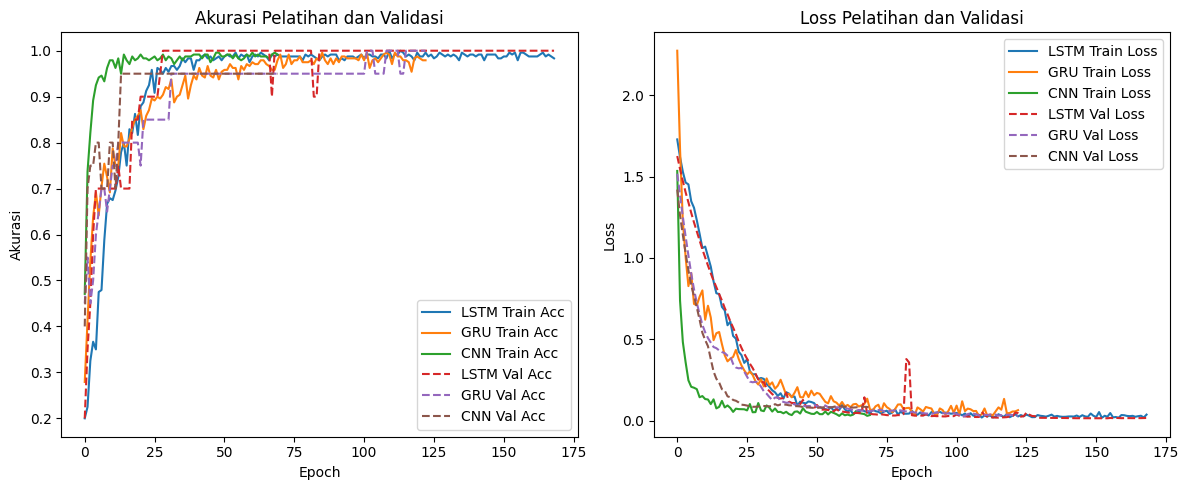

In [43]:
# --- 5. Pembangunan dan Pelatihan Model - Plot Hasil ---
print("\n--- Plotting Hasil Pelatihan ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['categorical_accuracy'], label='LSTM Train Acc')
plt.plot(history_gru.history['categorical_accuracy'], label='GRU Train Acc')
plt.plot(history_cnn.history['categorical_accuracy'], label='CNN Train Acc')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='LSTM Val Acc', linestyle='--')
plt.plot(history_gru.history['val_categorical_accuracy'], label='GRU Val Acc', linestyle='--')
plt.plot(history_cnn.history['val_categorical_accuracy'], label='CNN Val Acc', linestyle='--')
plt.title("Akurasi Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Akurasi")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss', linestyle='--')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss', linestyle='--')
plt.title("Loss Pelatihan dan Validasi")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

## **b. Evaluasi Model**


--- Evaluasi Performa Model di Validation Set ---

=== Validation Performance ===


,acc,prec,f1
model,,,
LSTM,0.95,0.96,0.949
GRU,0.95,0.96,0.949
CNN,1.00,1.00,1.000



--- Classification Report untuk Model Terbaik (CNN) ---
                        precision    recall  f1-score   support

        Angkat Pinggul       1.00      1.00      1.00         4
         Angkat Tangan       1.00      1.00      1.00         4
           Lutut Turun       1.00      1.00      1.00         4
Naikan Kepalan Kedepan       1.00      1.00      1.00         4
            Rentangkan       1.00      1.00      1.00         4

              accuracy                           1.00        20
             macro avg       1.00      1.00      1.00        20
          weighted avg       1.00      1.00      1.00        20



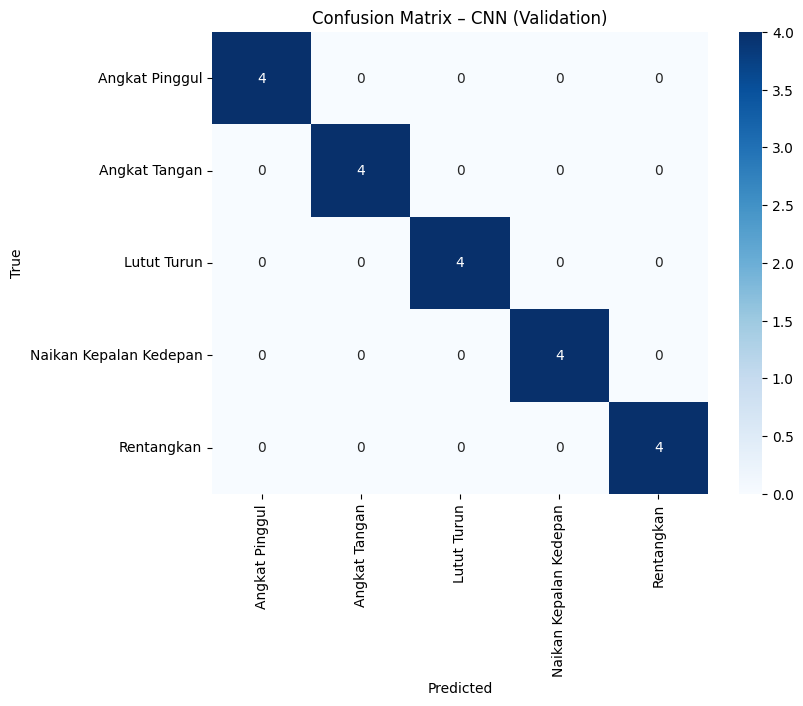

In [44]:
# --- 6. Evaluasi Model ---
print("\n--- Evaluasi Performa Model di Validation Set ---")
def eval_val(model, X_data_scaled, y_true_one_hot):
    y_prob = model.predict(X_data_scaled, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_true_one_hot, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    return acc, prec, rec, f1, y_true, y_pred

models_to_eval = {
    'LSTM': {'path': 'model rombak preprocessing/lstm_best.keras', 'data_scaled': X_val_scaled},
    'GRU': {'path': 'model rombak preprocessing/gru_best.keras', 'data_scaled': X_val_scaled},
    'CNN': {'path': 'model rombak preprocessing/cnn_best.keras', 'data_scaled': X_val_scaled}
}

scores = []
for name, config in models_to_eval.items():
    m = load_model(config['path'])
    acc, prec, rec, f1, _, _ = eval_val(m, config['data_scaled'], y_val_one_hot)
    scores.append(dict(model=name, acc=acc, prec=prec, f1=f1)) # Perbaikan: gunakan key 'f1'

perf = pd.DataFrame(scores).set_index('model').round(3)
print('\n=== Validation Performance ===')
display(perf)

best_model_name = perf['f1'].idxmax()
best_model = load_model(models_to_eval[best_model_name]['path'])
acc, prec, rec, f1, y_true_val, y_pred_val = eval_val(best_model, models_to_eval[best_model_name]['data_scaled'], y_val_one_hot)

print(f"\n--- Classification Report untuk Model Terbaik ({best_model_name}) ---")
print(classification_report(y_true_val, y_pred_val, target_names=actions, zero_division=0))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_val, y_pred_val, labels=range(num_classes))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=actions, yticklabels=actions, cmap='Blues')
plt.title(f'Confusion Matrix – {best_model_name} (Validation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

import shutil
if not os.path.exists('keypoints.zip'):
    shutil.make_archive('keypoints', 'zip', 'keypoints')
    print("\nFolder keypoints telah dikompres menjadi keypoints.zip")


In [45]:
import shutil

# Kompres folder 'keypoint' jadi 'keypoint.zip' di direktori kerja
shutil.make_archive('/kaggle/working/keypoints', 'zip', '/kaggle/working/keypoints')


'c:\\kaggle\\working\\keypoints.zip'

# **6. Inferensi Model**

## **a. Inferensi Klasifikasi Gerakan**

In [ ]:
# --- 7. Inferensi Model - a. Inferensi Klasifikasi Gerakan ---
print("\n--- Inferensi Model - Klasifikasi Gerakan ---")

# ------------ Parameter ---------------\
SEQ_LEN       = 30 # Harus sama dengan SEQ_LEN saat training
DETECT_THRESH = 0.7 # Ambang batas keyakinan deteksi (bisa disesuaikan)
# LABELS = np.array(['Angkat Pinggul', 'Kaki Kebelakang', 'Lutut Turun', 'Naikan Kepalan Kedepan', 'Rentangkan'])
# Gunakan array ACTIONS yang sudah didefinisikan di awal notebook
LABELS = np.array(actions)

# ------------ Load model ---------------\
# Asumsi model terbaik yang akan digunakan untuk inferensi
inference_model = load_model(models_to_eval[best_model_name]['path']) 
pose_model = YOLO('yolov8n-pose.pt') # YOLOv8 pose model

# ------------ Buffer sequence -----------\
buf = deque(maxlen=SEQ_LEN)

cap = cv2.VideoCapture(0) # Menggunakan webcam (0)

# --- Fungsi Ekstraksi Keypoints untuk Inferensi (Konsisten dengan Training) ---
def extract_and_normalize_keypoints_inference(results, frame_shape):
    num_kpts_features = 17 * 2 # Hanya x,y koordinat
    
    # Inisialisasi keypoints_flat dengan nol jika tidak ada deteksi
    keypoints_flat = np.zeros(num_kpts_features, dtype='float32')

    if results is not None and len(results.keypoints.xy) > 0:
        # Ambil keypoint orang pertama (xy format)
        kps = results.keypoints.xy[0].cpu().numpy()  # (17, 2) array of [x, y]
        
        if kps.shape[0] == 17: # pastikan 17 keypoints
            h, w, _ = frame_shape
            # Normalisasi koordinat X dan Y ke rentang 0-1
            normalized_kps = kps / np.array([w, h])
            keypoints_flat = normalized_kps.flatten()
    
    return keypoints_flat.astype('float32')

print("Memulai inferensi klasifikasi gerakan. Tekan 'ESC' untuk keluar.")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # ------------ YOLO Pose Estimation -------------\
    results_yolo = pose_model.predict(frame, verbose=False)
    
    # Ekstrak dan normalisasi keypoints (34 fitur)
    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    buf.append(keypoints_current_frame)

    # Lakukan inferensi hanya jika buffer sudah penuh
    pred_label = "Menunggu Gerakan..."
    last_conf = 0.0

    if len(buf) == SEQ_LEN:
        # Konversi buffer ke numpy array dan reshape untuk input model
        seq_input = np.array(buf).reshape(1, SEQ_LEN, num_kpts_features)
        
        # --- Terapkan StandardScaler (sama seperti saat training) ---
        # scaler_inference = scaler # Gunakan scaler yang sudah di-fit saat training
        seq_input_flat = seq_input.reshape(-1, num_kpts_features)
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, num_kpts_features)
        
        # Lakukan prediksi menggunakan model klasifikasi
        probs = inference_model.predict(seq_input_scaled, verbose=0)[0] 
        idx_pred = int(np.argmax(probs))
        last_conf = float(probs[idx_pred])
        pred_label = LABELS[idx_pred]

        # Filter prediksi dengan confidence rendah
        if last_conf < DETECT_THRESH:
            pred_label = "Tidak Yakin"

    # ---------- Tampilkan Hasil Inferensi di Frame ----------
    text = f"Pose: {pred_label} ({last_conf*100:.1f}%)"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0) if last_conf > DETECT_THRESH else (0, 0, 255), 2)

    # ---------- Gambar Keypoints (untuk visualisasi) ----------
    # Gunakan keypoints dari hasil YOLO mentah untuk menggambar
    if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
        annotated_frame = results_yolo[0].plot() # YOLOv8 plot() sudah menggambar keypoints
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', annotated_frame)
    else:
        cv2.imshow('YOLOv8 Pose + Model Klasifikasi', frame) # Tampilkan frame asli jika tidak ada deteksi

    if cv2.waitKey(1) & 0xFF == 27: # ESC keluar
        break

cap.release()
cv2.destroyAllWindows()


--- Inferensi Model - Klasifikasi Gerakan ---
Memulai inferensi klasifikasi gerakan. Tekan 'ESC' untuk keluar.


NameError: name 'num_kpts_features' is not defined

: 

## **b. Inferensi Lanjutan**

In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Asisten Rehabilitasi) ---
print("\n--- Inferensi Model - Asisten Rehabilitasi ---")

# ---------- LABEL TETAP (sesuai training) ----------
# Gunakan array ACTIONS yang sudah didefinisikan di awal notebook
LABELS_WORKFLOW = np.array(actions)

# ---------- URUTAN LATIHAN (bebas diubah) ----------
WORKFLOW = np.array(['Angkat Tangan', 'Naikan Kepalan Kedepan', 'Rentangkan', 'Lutut Turun', 'Angkat Pinggul'])

# ---------- PARAMETER LAIN ----------
SEQ_LEN = 30 # Harus sama dengan SEQ_LEN saat training
DETECT_THRESH_MAIN_MODEL = 0.70 # Ambang batas keyakinan deteksi dari model utama

# Ambang batas progres untuk feedback (dalam rentang 0.0 - 1.0)
THRESHOLD_PARTIAL = 0.30  # Gerakan tidak sempurna (misal, 30% progres)
THRESHOLD_GOOD = 0.70     # Gerakan sempurna (misal, 70% progres)

# Durasi konfirmasi state (dalam jumlah frame)
CONFIRMATION_FRAMES_COMPLETE = 10 # Jika gerakan 'Sempurna' terdeteksi selama X frame berturut-turut
INACTIVITY_FRAMES_RESET = 30 # Jika tidak ada deteksi solid selama X frame, reset state

FONT = cv2.FONT_HERSHEY_SIMPLEX

# --- Load model (model terbaik dari training) ---
inference_model_workflow = load_model(models_to_eval[best_model_name]['path']) 
pose_model_workflow = YOLO('yolov8n-pose.pt') # YOLOv8 pose model

# --- Fungsi untuk Menghitung Progres Gerakan (HARUS DISESUAIKAN) ---
def calculate_movement_progress(current_kps_normalized, action_name, calibration_params):
    # current_kps_normalized: numpy array (17, 2) keypoint yang sudah dinormalisasi [0,1].
    # calibration_params: Dictionary parameter kalibrasi untuk setiap gerakan.
    
    progress = 0.0

    if action_name == "Angkat Tangan":
        # Keypoints: kp_9 (pergelangan kiri), kp_10 (pergelangan kanan)
        wrist_y_avg = (current_kps_normalized[9][1] + current_kps_normalized[10][1]) / 2
        min_y = calibration_params.get('min_y_wrist_at_100', 0.1) 
        max_y = calibration_params.get('max_y_wrist_at_0', 0.7)   
        if (max_y - min_y) > 0:
            progress = (max_y - wrist_y_avg) / (max_y - min_y)
        else:
            progress = 0.0

    elif action_name == "Angkat Pinggul":
        # Keypoints: kp_11 (pinggul kiri), kp_12 (pinggul kanan)
        hip_y_avg = (current_kps_normalized[11][1] + current_kps_normalized[12][1]) / 2
        min_y = calibration_params.get('min_y_hip_at_100', 0.6) 
        max_y = calibration_params.get('max_y_hip_at_0', 0.8)   
        if (max_y - min_y) > 0:
            progress = (max_y - hip_y_avg) / (max_y - min_y)
        else:
            progress = 0.0
            
    elif action_name == "Rentangkan":
        # Keypoints: kp_5 (bahu kiri), kp_6 (bahu kanan), kp_9 (pergelangan kiri), kp_10 (pergelangan kanan)
        hip_x_avg = (current_kps_normalized[11][0] + current_kps_normalized[12][0]) / 2
        dist_right_arm_x = current_kps_normalized[10][0] - hip_x_avg
        dist_left_arm_x = hip_x_avg - current_kps_normalized[9][0]
        max_abs_dist_x = max(dist_right_arm_x, dist_left_arm_x)

        min_x = calibration_params.get('min_x_stretch_observed', 0.05)
        max_x = calibration_params.get('max_x_stretch_observed', 0.35)
        
        if (max_x - min_x) > 0:
            progress = (max_abs_dist_x - min_x) / (max_x - min_x)
        else:
            progress = 0.0

    return np.clip(progress, 0.0, 1.0)

# --- Parameter Kalibrasi Gerakan (PENTING: Sesuaikan Ini!) ---
# Anda harus mengisi nilai-nilai ini berdasarkan analisis data training Anda.
# Lakukan EDA untuk setiap gerakan untuk menemukan rentang [0,1] yang sesuai.
CALIBRATION_PARAMS = {
    "Angkat Tangan": {
        'min_y_wrist_at_100': 0.1, # Y pergelangan tangan saat 100% terentang ke atas
        'max_y_wrist_at_0': 0.7    # Y pergelangan tangan saat 0% terentang (tangan di samping tubuh)
    },
    "Angkat Pinggul": {
        'min_y_hip_at_100': 0.6,   # Y pinggul saat 100% terangkat
        'max_y_hip_at_0': 0.8      # Y pinggul saat 0% terangkat (posisi awal)
    },
    "Rentangkan": {
        'min_x_stretch_observed': 0.05, # Jarak X minimal saat tangan di samping
        'max_x_stretch_observed': 0.35  # Jarak X maksimal saat tangan terentang penuh
    },
    # Tambahkan kalibrasi untuk gerakan lainnya
    "Lutut Turun": {}, # Placeholder
    "Naikan Kepalan Kedepan": {} # Placeholder
}

# --- Inisialisasi State Machine ---
current_main_action = "Idle" 
current_progress_stage = "Menunggu Gerakan..." 
main_action_counter = 0 
progress_stage_counter = 0 
frames_since_last_detection = 0 
keypoint_sequence_buffer_workflow = deque(maxlen=SEQ_LEN) # Buffer terpisah untuk workflow

idx_workflow_step = 0 # Melacak langkah workflow saat ini
t_ex_start = time.time() # Timer untuk durasi latihan
popup_phase = None # None | 'result' | 'prep'
popup_start = None
score_workflow = {w: None for w in WORKFLOW} # Skor untuk setiap langkah workflow

print("Memulai Asisten Rehabilitasi. Tekan 'ESC' untuk keluar.")
cap = cv2.VideoCapture(0) # Menggunakan webcam (0)

while cap.isOpened() and idx_workflow_step < len(WORKFLOW):
    ok, frame = cap.read()
    if not ok:
        break

    # ------------ YOLO Pose Estimation -------------\
    results_yolo = pose_model_workflow.predict(frame, verbose=False)
    bgr = frame.copy() # Salinan frame untuk menggambar keypoint dan HUD

    # Ekstrak dan normalisasi keypoints (34 fitur)
    keypoints_current_frame = extract_and_normalize_keypoints_inference(results_yolo[0], frame.shape)
    keypoint_sequence_buffer_workflow.append(keypoints_current_frame)

    # Lakukan inferensi model utama hanya jika buffer sudah penuh dan tidak ada popup
    predicted_action_from_model = "None"
    prediction_confidence = 0.0
    
    if len(keypoint_sequence_buffer_workflow) == SEQ_LEN and popup_phase is None:
        seq_input = np.array(keypoint_sequence_buffer_workflow).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        # Terapkan StandardScaler (sama seperti saat training)
        seq_input_flat = seq_input.reshape(-1, keypoints_current_frame.shape[0])
        seq_input_scaled = scaler.transform(seq_input_flat).reshape(1, SEQ_LEN, keypoints_current_frame.shape[0])
        
        prediction_probs = inference_model_workflow.predict(seq_input_scaled, verbose=0)
        predicted_action_idx = np.argmax(prediction_probs)
        prediction_confidence = np.max(prediction_probs)
        
        if prediction_confidence >= DETECT_THRESH_MAIN_MODEL:
            predicted_action_from_model = LABELS_WORKFLOW[predicted_action_idx]

    # --- Logika State Machine ---
    pop_up_message = ""
    target_action = WORKFLOW[idx_workflow_step] # Gerakan target saat ini

    if popup_phase is None: # Hanya proses state machine jika tidak ada popup
        
        # Cek durasi latihan
        remaining_time = EXER_TIME - int(time.time() - t_ex_start)
        if remaining_time <= 0:
            pop_up_message = f"*** POP-UP: Gerakan '{target_action}' Gagal (Waktu Habis)! ***"
            score_workflow[target_action] = False
            popup_phase = 'result'
            remaining_time = 0 # Pastikan tidak negatif

        elif predicted_action_from_model == target_action:
            frames_since_last_detection = 0 # Reset counter karena ada deteksi solid
            
            if current_main_action == "Idle" or current_main_action != target_action:
                current_main_action = target_action
                current_progress_stage = "Tidak Bergerak" # Default awal
                progress_stage_counter = 0
                main_action_counter = 0 
                pop_up_message = f"Mendeteksi Gerakan: '{current_main_action}'"

            elif predicted_action_from_model == current_main_action:
                main_action_counter += 1 
                
                # Hitung progres gerakan spesifik
                progress_value = calculate_movement_progress(keypoints_current_frame, current_main_action, CALIBRATION_PARAMS.get(current_main_action, {}))

                # --- Transisi Tahap Progres ---
                if progress_value >= THRESHOLD_GOOD:
                    if current_progress_stage != "Sempurna":
                        current_progress_stage = "Sempurna"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1 
                    pop_up_message = f"'{current_main_action}': Gerakan Sempurna ({int(progress_value*100)}%)"

                elif progress_value >= THRESHOLD_PARTIAL:
                    if current_progress_stage != "Tidak Sempurna":
                        current_progress_stage = "Tidak Sempurna"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1
                    pop_up_message = f"'{current_main_action}': Gerakan Tidak Sempurna ({int(progress_value*100)}%)"

                else: 
                    if current_progress_stage != "Tidak Bergerak":
                        current_progress_stage = "Tidak Bergerak"
                        progress_stage_counter = 0 
                    progress_stage_counter += 1
                    pop_up_message = f"'{current_main_action}': Gerakan Tidak Bergerak ({int(progress_value*100)}%)"

                # --- Cek Penyelesaian Gerakan (Sempurna) ---
                if current_progress_stage == "Sempurna" and progress_stage_counter >= CONFIRMATION_FRAMES_COMPLETE:
                    pop_up_message = f"*** POP-UP: Gerakan '{current_main_action}' Berhasil Diselesaikan dengan Sempurna! ***"
                    score_workflow[current_main_action] = True
                    popup_phase = 'result' # Tampilkan popup hasil
                    # State akan direset setelah popup

        else: # Model mendeteksi aksi lain atau "None" saat sudah dalam sebuah aksi utama
            frames_since_last_detection += 1
            if current_main_action != "Idle" and frames_since_last_detection >= INACTIVITY_FRAMES_RESET:
                pop_up_message = f"*** POP-UP: Gerakan '{current_main_action}' Gagal (Tidak Ada Gerakan Terdeteksi)! ***"
                score_workflow[current_main_action] = False
                popup_phase = 'result'
                frames_since_last_detection = 0
                # State akan direset setelah popup

        # --- Tampilan HUD (Head-Up Display) ---
        cv2.rectangle(bgr, (0, 0), (640, 60), (0, 0, 0), -1)
        cv2.putText(bgr,
                    f'Aksi Target: {target_action}   |   Timer: {remaining_time:02d}s',
                    (10, 25), FONT, 0.6, (255, 255, 255), 2)

        det_txt = f"Deteksi: '{predicted_action_from_model}' ({prediction_confidence*100:4.1f}%)"
        cv2.putText(bgr, det_txt, (10, 50), FONT, 0.6, (0, 255, 255), 2)

        cv2.rectangle(bgr, (0, 440), (640, 480), (0, 0, 0), -1)
        cv2.putText(bgr, f'Status: {current_progress_stage}', (10, 470), FONT, 0.7, (0, 255, 255), 2)
        
        # Gambar keypoints dari hasil YOLO mentah
        if results_yolo[0].keypoints is not None and len(results_yolo[0].keypoints.xy) > 0:
            annotated_frame = results_yolo[0].plot()
            bgr = annotated_frame # Gunakan frame dengan anotasi YOLO
        
        cv2.imshow('Rehab-Assist', bgr)
        key = cv2.waitKey(1) & 0xFF
        if key == 27: # ESC
            break

    # --- Logika POP-UP (Result / Prep) ---
    if popup_phase is not None:
        key = cv2.waitKey(10) & 0xFF
        
        if popup_phase == 'result':
            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr,
                        f"Gerakan '{target_action}' : " + ('BERHASIL' if score_workflow[target_action] else 'GAGAL'),
                        (60, 190), FONT, 0.8, (255, 255, 255), 2)

            if idx_workflow_step + 1 < len(WORKFLOW):
                cv2.putText(bgr, 'Tekan ENTER untuk lanjut',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)
            else:
                cv2.putText(bgr, 'Sesi selesai, tekan ESC untuk keluar',
                            (60, 230), FONT, 0.7, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if key in (13, 10): # ENTER key
                popup_phase = 'prep'
                popup_start = time.time()
                # Reset state untuk langkah workflow berikutnya
                current_main_action = "Idle"
                current_progress_stage = "Menunggu Gerakan..."
                main_action_counter = 0
                progress_stage_counter = 0
                frames_since_last_detection = 0
                keypoint_sequence_buffer_workflow.clear()

        elif popup_phase == 'prep':
            elap = time.time() - popup_start
            cnt = POPUP_TIME - int(elap)

            cv2.rectangle(bgr, (40, 140), (600, 270), (0, 0, 0), -1)
            cv2.putText(bgr, f"Siapkan gerakan : '{WORKFLOW[idx_workflow_step+1]}'",
                        (60, 190), FONT, 0.7, (255, 255, 255), 2)
            cv2.putText(bgr, f"Mulai dalam {cnt:02d} dtk",
                        (60, 230), FONT, 0.9, (0, 255, 255), 2)

            cv2.imshow('Rehab-Assist', bgr)
            if elap >= POPUP_TIME:
                idx_workflow_step += 1
                t_ex_start = time.time() # Reset timer latihan
                popup_phase = None
                # State sudah direset saat transisi dari 'result' ke 'prep'

        if key == 27: # ESC
            break

cap.release()
cv2.destroyAllWindows()

In [ ]:
# --- 7. Inferensi Model - b. Inferensi Lanjutan (Skor Akhir) ---
print('\n--- Skor Akhir Sesi Rehabilitasi ---')
for act in WORKFLOW:
    status = "✓" if score_workflow.get(act) else "✗" # Gunakan .get() untuk keamanan
    print(f'{act:<25}: {status}')

Skor akhir:
Angkat Tangan            : ✗
